In [1]:
import torch
import numpy as np
import sklearn

torch.manual_seed(42)
np.random.seed(42)

In [2]:
import torch
from torch import nn


class Network(nn.Module):
    def __init__(self, num_hidden=2, dropout=0., in_feats=2048, num_classes=2):
        super(Network, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=7, padding=3),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(16, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )
        self.avgpool = nn.AvgPool1d(2, stride=2)
        self.block4 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.fc = nn.Linear(384, 2)
        
    def forward(self, x):
        x = self.block1(x.unsqueeze(1))
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [3]:
Network(dropout=0.5)

Network(
  (block1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): Conv1d(16, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (block4): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=384, out_features=2, bias=True)
)

In [4]:
import numpy as np
import random
from functools import partial

from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class ConductanceDataset(Dataset):
    SUPPORTED_OOD_SAMPLING = ['random', 'frog', 'horse']
    
    def __init__(self, ID_conductance: np.array, OOD_conductance: np.array, ood_sampling='random', transform=None, target_transform=None):
        super(ConductanceDataset, self).__init__()
        assert ood_sampling in self.SUPPORTED_OOD_SAMPLING, 'Back off you Bastard'
        
        
        #IxA
        self.ID_conductance = ID_conductance
        #TxIxA
        self.OOD_conductance = OOD_conductance
        self.ood_sampling_function = self._build_sampling_function(ood_sampling)
        self.transform = transform
        self.target_transform = target_transform
        
    @staticmethod
    def _build_sampling_function(sampling_strategy):
        if sampling_strategy == 'random':
            return partial(random.randint, a=0, b=1)
        elif sampling_strategy == 'frog':
            return lambda x: 0
        elif sampling_strategy == 'horse':
            return lambda x: 1
        
    def __len__(self):
        return len(self.ID_conductance) + self.OOD_conductance.shape[1]
    
    def __getitem__(self, ix):
        try:
            conductance = self.ID_conductance[ix]
            target = 'ID'
        except IndexError:
            which_class = self.ood_sampling_function()
            conductance = self.OOD_conductance[which_class, ix - len(self.ID_conductance)]
            target = 'OOD'
        
        if self.transform is not None:
            conductance = self.transform(conductance)
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return {'ix': ix, 'conductance': conductance, 'target': target}

In [19]:
import os
import numpy as np

CONDUCTANCE_DIR = './zf_net_conductance'
layers = ['conv1']
# layers = ['conv1']

ID_val_image_indices = None
ID_test_image_indices = None
ID_image_indices = None
OOD_image_indices = None
    
ID_val_logits = np.load(os.path.join(CONDUCTANCE_DIR, f'val_logits_.npy')).astype('float32')
ID_val_index = np.load(os.path.join(CONDUCTANCE_DIR, f'val_ids_conv1_.npy')).astype('int')

ID_test_logits = np.load(os.path.join(CONDUCTANCE_DIR, f'test-id_logits_.npy')).astype('float32')
ID_test_index = np.load(os.path.join(CONDUCTANCE_DIR, f'test-id_ids_conv1.npy')).astype('float32')

OOD_test_logits = np.load(os.path.join(CONDUCTANCE_DIR, f'test-ood_logits_.npy')).astype('float32')
OOD_test_index = np.load(os.path.join(CONDUCTANCE_DIR, f'test-ood_ids_conv1.npy'))

ID_val_sort = np.argsort(ID_val_index)
ID_test_sort = np.argsort(ID_test_index)
OOD_test_sort = np.argsort(OOD_test_index)

ID_val_image_indices = ID_val_index[ID_val_sort]
ID_test_image_indices = ID_test_index[ID_test_sort]
ID_image_indices = np.concatenate((ID_val_image_indices, ID_test_image_indices))
OOD_image_indices = OOD_test_index[OOD_test_sort]

ID_logits = np.concatenate((ID_val_logits[ID_val_sort], ID_test_logits[ID_test_sort]), axis=0)
OOD_logits = OOD_test_logits[OOD_test_sort]

In [20]:
print(ID_logits.shape)
print(OOD_logits.shape)

(3000, 2)
(8000, 2)


In [21]:
from scipy.special import softmax

ID_softmax = softmax(ID_logits, axis=-1)
OOD_softmax = softmax(OOD_logits, axis=-1)
print(len(OOD_softmax))

8000


In [22]:
from sklearn.model_selection import train_test_split

idx = np.arange(len(ID_softmax))
ID_train_idx, ID_test_idx = train_test_split(idx, test_size=0.1)
ID_train_idx, ID_val_idx = train_test_split(ID_train_idx, test_size=0.1481)

ID_train = ID_softmax[ID_train_idx]
ID_val = ID_softmax[ID_val_idx]
ID_test = ID_softmax[ID_test_idx]

idx = np.arange(len(OOD_softmax))
OOD_train_idx, OOD_test_idx = train_test_split(idx, test_size=0.66)
OOD_train_idx, OOD_val_idx = train_test_split(OOD_train_idx, test_size=0.15)

OOD_train = OOD_softmax[OOD_train_idx]
OOD_val = OOD_softmax[OOD_val_idx]
OOD_test = OOD_softmax[OOD_test_idx]

print(f"data_distribution: \n"
    f"ID examples: {len(ID_train)} {len(ID_val)} {len(ID_test)},\n"
    f"OOD examples: {OOD_train.shape[1]} {OOD_val.shape[1]} {OOD_test.shape[1]}")

data_distribution: 
ID examples: 2300 400 300,
OOD examples: 2 2 2


In [8]:
label_map = {'OOD': 0, 'ID': 1}
def map_label(label_name):
    return label_map[label_name]

In [9]:
from torch.utils.data import DataLoader

train_dataset = ConductanceDataset(ID_conductance=ID_train, OOD_conductance=OOD_train, ood_sampling='random', target_transform=map_label)
train_loader = DataLoader(train_dataset, batch_size=64, pin_memory=True, drop_last=False, shuffle=True, num_workers=0)

In [10]:
val_dataset = ConductanceDataset(ID_conductance=ID_val, OOD_conductance=OOD_val, ood_sampling='random', target_transform=map_label)
val_loader = DataLoader(val_dataset, batch_size=64, pin_memory=True, drop_last=False, shuffle=False, num_workers=0)

In [11]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = 'cuda:0'
net = Network(dropout=0.5).to(device)
criterion = CrossEntropyLoss(reduction='mean').to(device)
optimizer = SGD(params=net.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, patience=10, cooldown=10, factor=0.1, verbose=True)

In [12]:
import torch
from collections import defaultdict
from tqdm import tqdm
import json

In [13]:
from inferno.utils.train_utils import AverageMeter
from sklearn.metrics import classification_report

best_epoch = 0
best_loss = np.inf
best_acc = 0
times_it_was_wrong = np.zeros(len(val_loader.dataset), dtype='int')
for epoch in range(100):
    print(f'epoch: {epoch}')
    
    net.train()
    train_trackers = defaultdict(AverageMeter)
    all_labels, all_preds = [], []
    for sample in train_loader:
        ix = sample['ix']
        conductance = sample['conductance']
        target = sample['target']
        
        conductance = conductance.to(device)
        target = target.to(device)
        
        logits = net(conductance)
        loss = criterion(logits, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        all_labels.extend(target.cpu().detach().numpy().tolist())
        all_preds.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
        train_trackers['loss'].update(loss.item())
        
    print('train: {}'.format({k: v.avg for k, v in train_trackers.items()}))
    print(f'train acc: {classification_report(y_true=all_labels, y_pred=all_preds, output_dict=True)["accuracy"]}')
        
    net.eval()
    val_trackers = defaultdict(AverageMeter)
    all_labels, all_preds = [], []
    for sample in val_loader:
        ix = sample['ix']
        conductance = sample['conductance']
        target = sample['target']  
          
        conductance = conductance.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = net(conductance)
          
        preds = logits.argmax(dim=1)
        wrong_mask = (preds != target)
        times_it_was_wrong[ix.numpy()[wrong_mask.cpu().numpy()]] += 1
            
        loss = criterion(logits, target)
        
        all_labels.extend(target.cpu().detach().numpy().tolist())
        all_preds.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
        val_trackers['loss'].update(loss.item())
    
    print('val: {}'.format({k: v.avg for k, v in val_trackers.items()}))
    val_acc = classification_report(y_true=all_labels, y_pred=all_preds, output_dict=True)["accuracy"]
    print(f'val acc: {val_acc}')
    
    val_loss = val_trackers['loss'].avg
    scheduler.step(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(net.state_dict(), 'best.pth')
    if val_acc > best_acc:
        best_epoch = epoch
        best_acc = val_acc

print(np.unique(times_it_was_wrong, return_counts=True))

epoch: 0
train: {'loss': 0.6030209766675348}
train acc: 0.6741110147441457
val: {'loss': 0.7859984177809495}
val acc: 0.49504950495049505
epoch: 1


/home/william/anaconda3/envs/hammersack/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train: {'loss': 0.5406247263085352}
train acc: 0.7443625325238509
val: {'loss': 0.5593705842128167}
val acc: 0.7116336633663366
epoch: 2
train: {'loss': 0.5080145078979127}
train acc: 0.7617085862966175
val: {'loss': 0.523580768933663}
val acc: 0.7413366336633663
epoch: 3
train: {'loss': 0.47608884638302945}
train acc: 0.7799219427580225
val: {'loss': 0.5302021113725809}
val acc: 0.7153465346534653
epoch: 4
train: {'loss': 0.46744524697734885}
train acc: 0.7853425845620121
val: {'loss': 0.49568434861990124}
val acc: 0.7648514851485149
epoch: 5
train: {'loss': 0.45264922021186516}
train acc: 0.7872940156114484
val: {'loss': 0.4736820711539342}
val acc: 0.775990099009901
epoch: 6
train: {'loss': 0.43258960157224574}
train acc: 0.8022549869904597
val: {'loss': 0.4902326327103835}
val acc: 0.7574257425742574
epoch: 7
train: {'loss': 0.42529219225661397}
train acc: 0.8046400693842151
val: {'loss': 0.46439285003221953}
val acc: 0.7871287128712872
epoch: 8
train: {'loss': 0.41922646679290354}

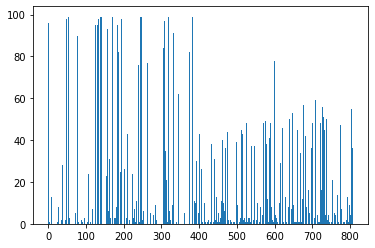

In [15]:
import matplotlib.pyplot as plt
plt.bar(range(len(times_it_was_wrong)), times_it_was_wrong)
plt.show()

In [16]:
best_loss

0.390312508894847

In [17]:
best_acc

0.8341584158415841

In [18]:
best_epoch

54

In [19]:
# TODO: check this madness for bugs to make sure the image indices are tracking back to the right place. Possible off-by-one, possibly totally incorrect

k = 20
top_k_idx = np.argpartition(times_it_was_wrong, -k)[-k:]

ID_val_worst_images = []
ID_test_worst_images = []
OOD_test_worst_images = []
for ds_ix in top_k_idx:
    try:
        try:
            all_ds_ix = ID_val_idx[ds_ix]
            image_ix = ID_val_image_indices[all_ds_ix]
            ID_val_worst_images.append(image_ix)
        except IndexError:
            image_ix = ID_test_image_indices[all_ds_ix - len(ID_val_image_indices)]
            ID_test_worst_images.append(image_ix)
    except IndexError:    
        image_ix = OOD_image_indices[OOD_val_idx][ds_ix - len(ID_image_indices)]
        OOD_test_worst_images.append(image_ix)
        
        
print(ID_val_worst_images)
print(ID_test_worst_images)
print(OOD_test_worst_images)

[28169, 35812, 960]
[8932, 1572, 9899, 6809, 7192, 7117, 4750, 5607, 5434, 9953, 6520, 1081, 1069, 4119, 4638, 5675, 4882]
[]


In [20]:
import math

def plot_n_images(figure, images, rows=None, cols=None):
    def iceil(fpn):
        return int(math.ceil(fpn))

    def isqrt(fpn):
        return int(math.sqrt(fpn))

    if rows is None and cols is None:
        rows = isqrt(len(images))
        cols = iceil(len(images)/rows)
    elif rows is None:
        rows = iceil(len(images)/cols)
    elif cols is None:
        cols = iceil(len(images)/rows)

    axes = []
    for idx in range(len(images)):
        ax = figure.add_subplot(rows, cols, idx+1)
        axes.append(ax)

    for im, ax in zip(images, axes):
        ax.imshow(im)
        ax.set_axis_off()

    figure.tight_layout()

    return axes

In [21]:
from torchvision import datasets

dataset_name = 'CIFAR10'
data_root = './data'
label_map = {6: 'frog', 7: 'horse'}

Files already downloaded and verified
Files already downloaded and verified


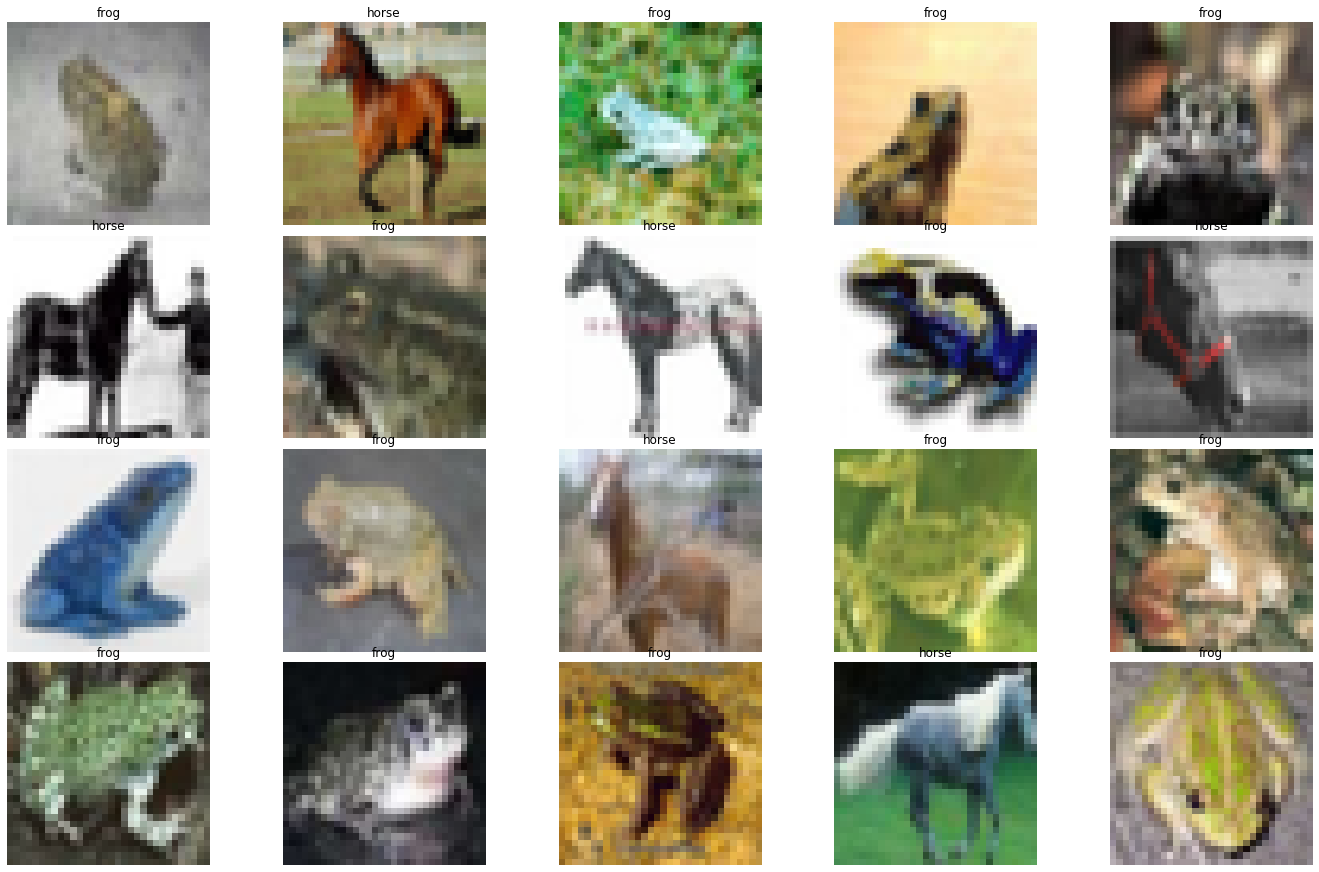

In [22]:
import matplotlib.pyplot as plt


images = []
labels = []
dataset = getattr(datasets, dataset_name)(root=data_root, train=True, download=True)
for ix in ID_val_worst_images:
    hard_image, label = dataset[ix]
    
    images.append(hard_image)
    labels.append(label_map[label])
    
dataset = getattr(datasets, dataset_name)(root=data_root, train=False, download=True)
for ix in ID_test_worst_images:
    hard_image, label = dataset[ix]
    
    images.append(hard_image)
    labels.append(label_map[label])
    
fig = plt.figure(figsize=(20, 12))
axes = plot_n_images(fig, images)
for ax, l in zip(axes, labels):
    ax.set_title(l)
    
plt.show()